In [1]:
import pandas as pd
import os

base_dir = 'profits'
strategy_files = os.listdir(base_dir)
strategy_names = [x.split('.')[0] for x in strategy_files if x != '.ipynb_checkpoints']
strategy_results = {x: pd.read_parquet('%s/%s.parquet' % (base_dir, x)) for x in strategy_names}

In [2]:
cols = ['symbol', 'date', 'open_adj', 'high_adj', 'low_adj',
        'close_adj', 'actual_enter', 'entrances', 'exits',
        'trade_count', 'next_open', 'profit', 'norm_profit',
        'avg_profit', 'avg_profit_std', 'eavg_profit', 'volume',
        'mv_avg', 'sector',  'regime_close', 'regime_ma',
        'sector_close', 'sector_ma', 'exit_date', 'exit_profit',
        'equity_curve_mv_avg', 'equity_curve_agg'] + strategy_names
for strategy in strategy_names:
    df = strategy_results[strategy]
    for strategy2 in strategy_names:
        df.loc[:, strategy2] = 0 if strategy != strategy2 else 1
    strategy_results[strategy] = df[cols].drop_duplicates(subset=['symbol', 'date'])

In [3]:
strategy_df = pd.concat((strategy_results[x] for x in strategy_results), axis=0)

In [ ]:
strategy_df.shape

#### A little exploratory analysis of signal frequency

In [4]:
sig_df = strategy_df.loc[strategy_df.actual_enter == 1]
sig_df = sig_df.dropna(subset=['profit'])

In [5]:
day_count = sig_df.groupby('date').agg({'close_adj': 'count'})

#### profit correlation analysis original feats

In [ ]:
import matplotlib.pyplot as plt
sig_df.loc[:, 'sig_count'] = sig_df['date'].map(day_count.close_adj)
for ind, col in enumerate(strategy_names):
    plt.figure(ind)
    df = sig_df.loc[sig_df[col] == 1]
    df.groupby('sig_count').agg({'norm_profit': 'mean'}).reset_index().plot(x='sig_count', y='norm_profit', kind='scatter')

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.offline as pyo
import plotly

pyo.init_notebook_mode()

fig = make_subplots(rows=3, cols=1, shared_xaxes=True)

sig_df.loc[:, 'sig_count'] = sig_df['date'].map(day_count.close_adj)
for ind, col in enumerate(strategy_names):
    df = sig_df.loc[sig_df[col] == 1]
    df.loc[:, 'avg_profit'] = df.avg_profit.shift(1)
    df = df.dropna()
    fig.add_trace(
        go.Histogram2d(x=df.avg_profit, y=df.norm_profit, histnorm='probability', name=col),
        row=(ind + 1), col=1
    )
fig

In [ ]:
import IPython.display as disp
for ind, col in enumerate(['MFIROC', 'RSIROC', 'STO']):
    df = sig_df.loc[(sig_df[col] == 1) & (sig_df.avg_profit != 0)]
    df.loc[:, 'avg_profit'] = df.avg_profit.shift(1)
    df = df.dropna()
    disp.display(df[['avg_profit', 'norm_profit', 'eavg_profit', 'sig_count']].corr('spearman'))

#### Feature Generation

In [6]:
tech_ind_cols = ['symbol', 'date', 'open_adj', 'high_adj', 'low_adj', 'close_adj', 'volume',
                 'mv_avg', 'sector', 'regime_close', 'regime_ma', 'sector_close', 'sector_ma']
candle_data = strategy_df[tech_ind_cols].drop_duplicates()

In [7]:
import ta
import numpy as np

def mean_atr(df, atr_period=14):
    df.loc[:, 'last_close'] = df.close_adj.shift(1)
    atr_high = np.maximum(df.high_adj, df.last_close)
    atr_low = np.minimum(df.high_adj, df.last_close)
    atr = atr_high - atr_low
    return atr, atr.ewm(span=atr_period, adjust=False).mean()

def mean_close_diff_norm(close, ma):
    return (close - ma) / ma

def generate_ta_features(sym_df, rsi_period=5, roc_period=45, fut_roc_period=5, mfi_period=5,
                         sto_period=14, atr_period=14, bba_period=20,
                         dch_period=20):
    sym_df = sym_df.sort_values('date')
    rsi = ta.momentum.RSIIndicator(close=sym_df.close_adj, n=rsi_period).rsi()
    roc = ta.momentum.ROCIndicator(sym_df.close_adj, n=roc_period).roc()
    roc_fut = ta.momentum.ROCIndicator(sym_df.close_adj, n=fut_roc_period).roc()
    mfi = ta.momentum.MFIIndicator(
        high=sym_df.high_adj, low=sym_df.low_adj,
        close=sym_df.close_adj, volume=sym_df.volume,
        n=mfi_period
    ).money_flow_index()
    sto = ta.momentum.StochIndicator(high=sym_df.high_adj, low=sym_df.low_adj, close=sym_df.close_adj,
                                     n=sto_period).stoch_signal()
    atr, mean_atr_var = mean_atr(sym_df, atr_period=atr_period)
    bb = ta.volatility.BollingerBands(close=sym_df.close_adj, n=bba_period)
    bb_high = bb.bollinger_hband()
    bb_low = bb.bollinger_lband()
    bba = bb_high - bb_low
    dc = ta.volatility.DonchianChannel(close=sym_df.close_adj, n=dch_period)
    dc_high = dc.donchian_channel_hband()
    dc_low = dc.donchian_channel_lband()
    dch = dc_high - dc_low
    sym_df.loc[:, 'rsi'] = rsi
    sym_df.loc[:, 'roc'] = roc
    sym_df.loc[:, 'fut_roc'] = roc_fut.shift(-fut_roc_period)
    sym_df.loc[:, 'mfi'] = mfi
    sym_df.loc[:, 'sto'] = sto
    sym_df.loc[:, 'atr'] = atr
    sym_df.loc[:, 'atr_norm'] = atr / sym_df.close_adj
    sym_df.loc[:, 'mean_atr'] = mean_atr_var
    sym_df.loc[:, 'mean_atr_norm'] = mean_atr_var / sym_df.close_adj
    sym_df.loc[:, 'bba'] = bba
    sym_df.loc[:, 'dch'] = dch
    sym_df.loc[:, 'bba_norm'] = bba / sym_df.close_adj
    sym_df.loc[:, 'dch_norm'] = dch / sym_df.close_adj
    sym_df.loc[:, 'ma_diff_norm'] = mean_close_diff_norm(sym_df.close_adj, sym_df.mv_avg)
    sym_df.loc[:, 'regime_ma_diff_norm'] = mean_close_diff_norm(sym_df.regime_close, sym_df.regime_ma)
    sym_df.loc[:, 'sector_ma_diff_norm'] = mean_close_diff_norm(sym_df.sector_close, sym_df.sector_ma)
    sym_df.loc[:, 'volatility'] = (sym_df.close_adj.diff() / sym_df.close_adj.shift(1)).abs().ewm(span=atr_period,
                                                                                                  adjust=False).mean()
    sym_df.loc[:, 'directional_strength'] = -(sym_df.close_adj.diff() / sym_df.close_adj.shift(1)).ewm(span=atr_period,
                                                                                                      adjust=False).mean()
    sym_df.loc[:, 'bar_range'] = (sym_df.close_adj - sym_df.low_adj) / (sym_df.high_adj - sym_df.low_adj)
    ta_cols = ['symbol', 'date', 'rsi', 'roc', 'mfi', 'sto', 'atr', 'mean_atr', 'bba', 'dch', 'fut_roc',
               'ma_diff_norm', 'regime_ma_diff_norm', 'sector_ma_diff_norm', 'volatility', 'bar_range', 'mean_atr_norm',
               'bba_norm', 'dch_norm', 'directional_strength'
               ]
    return sym_df[ta_cols]

In [8]:
from tqdm import tqdm

tqdm.pandas()
ta_feats = candle_data.groupby('symbol').progress_apply(lambda x: generate_ta_features(x))

100%|██████████████████████████████████████████████████████████████████████████████| 1261/1261 [02:01<00:00, 10.35it/s]


In [9]:
feat_df = strategy_df.merge(ta_feats.reset_index(drop=True), on=['symbol', 'date'])

In [10]:
def get_lag_feats(sym_df, sharp_period=100):
    sym_df = sym_df.sort_values('date')
    sym_df.loc[:, 'lag_eavg_profit'] = sym_df.eavg_profit.shift(1)
    sym_df.loc[:, 'lag_avg_profit'] = sym_df.avg_profit.shift(1)
    sym_df.loc[:, 'lag_avg_profit_std'] = sym_df.avg_profit_std.shift(1)
    sym_df.loc[:, 'lag_eavg_profit_std'] = sym_df.lag_eavg_profit.rolling(sharp_period).std()
    sym_df.loc[:, 'sharp_ratio'] = sym_df.lag_eavg_profit / sym_df.lag_eavg_profit_std
    lag_cols = ['date', 'symbol', 'strategy_ind', 'lag_eavg_profit', 'lag_avg_profit',
                'lag_eavg_profit_std', 'sharp_ratio']
    return sym_df[lag_cols]

In [11]:
import numpy as np

strat_w = np.arange(len(strategy_names))
feat_df.loc[:, 'strategy_ind'] = (feat_df[strategy_names] * strat_w).sum(axis=1)

In [12]:
lag_feats = feat_df.groupby(['symbol', 'strategy_ind']).progress_apply(lambda x: get_lag_feats(x, sharp_period=45))

100%|██████████████████████████████████████████████████████████████████████████████| 3783/3783 [01:31<00:00, 41.20it/s]


In [13]:
feature_df = feat_df.merge(lag_feats.reset_index(drop=True), on=['date', 'symbol', 'strategy_ind'])
feature_df.loc[:, 'sig_count'] = feature_df['date'].map(day_count.close_adj)

In [15]:
feature_df.loc[:, 'equity_curve_ratio'] = feature_df.equity_curve_agg / feature_df.equity_curve_mv_avg

#### Correlation analysis with profit and features

In [ ]:
feat_sig_df = feature_df.loc[feature_df.actual_enter == 1]

In [ ]:
feat_sig_df.loc[:, 'sig_count'] = feat_sig_df['date'].map(day_count.close_adj)

In [25]:
feat_col = ['rsi', 'roc', 'mfi', 'sto', 'bba', 'dch',
            'sig_count', 'sector_ma_diff_norm',
            'volatility', 'equity_curve_ratio'
            ] # left out lag_avg_profit , 'ma_diff_norm', 'sector_ma_diff_norm','regime_ma_diff_norm'
target_col = ['norm_profit']

In [ ]:
import seaborn as sbn
feat_sig_df[feat_col + target_col].corr()

In [ ]:
sym_df[['lag_eavg_profit', 'lag_eavg_profit_std', 'sharp_ratio']].plot(subplots=True)

In [ ]:
feature_df.loc[feature_df.symbol == 'XOM'][['lag_eavg_profit', 'lag_eavg_profit_std', 'sharp_ratio']].plot(subplots=True)

### Super Simple

In [ ]:
import datetime as dt
time_df = feature_df.loc[feature_df['date'] >= dt.datetime(2002, 1, 1)]
time_df.loc[(time_df.actual_enter == 1) | (time_df.exits == 1)].to_parquet('backtesting/small_mid_lrg_cap_signals.parquet')

### Maybe no machine learning

In [ ]:
## This is garbage. Come back and fix.

sig_cnt_thresh = 2
entrances = feature_df.loc[feature_df.exit_date.notnull()]
entrances = entrances.drop_duplicates(subset=['date', 'symbol'], keep='first')
entrances.loc[:, 'selection_rank'] = entrances.groupby('date').volatility.rank(ascending=False)
entrances = entrances.loc[entrances.selection_rank <= sig_cnt_thresh]
exits = feature_df.loc[feature_df.exit_profit.notnull()]

In [ ]:
def map_exit(strat_df):
    strategy_ind = strat_df.strategy_ind.iloc[0]
    strat_entrances = entrances.loc[entrances.strategy_ind == strategy_ind][['symbol', 'exit_date', 'profit']]
    strat_entrances.columns = ['symbol', 'exit_date', 'exit_profit']
    strat_df = strat_df.merge(strat_entrances[['symbol', 'exit_date', 'exit_profit']],
                              how='left', left_on=['symbol', 'date'], right_on=['symbol', 'exit_date'])
    strat_df = strat_df.loc[strat_df.exit_profit_y.notnull()]
    return strat_df

In [ ]:
exit_profits = feature_df.groupby('strategy_ind').apply(map_exit)

In [ ]:
def equity_adjustment(df):
    strategy_stats_df = pd.DataFrame({'date': df['date'].unique()}).sort_values('date')
    date_prof = df.groupby('date').exit_profit_y.sum().reset_index('date')
    strategy_stats_df = strategy_stats_df.merge(date_prof, on='date', how='left')
    strategy_stats_df.loc[:, 'cum_prof'] = strategy_stats_df.exit_profit_y.cumsum()
    strategy_stats_df.loc[:, 'cum_prof_mv_avg'] = strategy_stats_df.set_index('date').cum_prof.rolling('100d', min_periods=1).mean().values
    strategy_stats_df.loc[:, 'exit_profit2'] = strategy_stats_df.exit_profit_y
    strategy_stats_df.loc[:, 'strategy_on'] = (strategy_stats_df.cum_prof > strategy_stats_df.cum_prof_mv_avg).fillna(False)
    df = df.merge(strategy_stats_df['date', 'strategy_on'], how='left', on='date')
    df = df.loc[df.strategy_on]
    df.loc[:, 'erase_profit'] = 1
    
    strategy_stats_df.loc[~strategy_stats_df.strategy_on, 'exit_profit2'] =  0 
    strategy_stats_df.loc[:, 'cum_prof2'] = strategy_stats_df.exit_profit2.cumsum()
    return strategy_stats_df

In [ ]:
equity_adj_df = equity_adjustment(exit_profits)

In [ ]:
equity_adj_df.shape

In [ ]:
equity_adj_df.to_parquet('equity_curves/%s.parquet' % 'AGG')

In [ ]:
strategy_on_df = feature_df.merge(equity_adj_df[['date', 'strategy_on', 'exit_profit_y']], how='left', on='date')

In [ ]:
strategy_on_df.loc[:, 'strategy_on'] = strategy_on_df.strategy_on.fillna(method='ffill').fillna(True)

In [ ]:
strategy_on_df.loc[strategy_on_df.strategy_on, 'exit_profit_y'].sum(), strategy_on_df.exit_profit_y.sum()

In [ ]:
strategy_on_df.loc[strategy_on_df.strategy_on, 'profit'].sum(), strategy_on_df.profit.sum()

In [ ]:
import datetime as dt
time_df = strategy_on_df.loc[strategy_on_df['date'] >= dt.datetime(2002, 1, 1)]
time_df.loc[(time_df.actual_enter == 1) | (time_df.exits == 1)].to_parquet('backtesting/small_mid_lrg_cap_signals.parquet')

#### Machine Learning Time

In [17]:
import numpy as np
import datetime as dt

def get_ml_data(feature_df, feat_col, strategy_names, min_sig_cnt=2,
                train_date_range=(dt.datetime(2000, 1, 1), dt.datetime(2010, 12, 31)),
                test_date_range=(dt.datetime(2011, 1, 1), dt.datetime(2018, 1, 1))):
    notnull_index = (feature_df.norm_profit.notnull()) & (feature_df.sig_count > min_sig_cnt)
    aux_cols = ['date', 'norm_profit', 'symbol', 'cum_prof', 'cum_prof_mv_avg',
                'strategy_on']
    feats = feature_df.loc[notnull_index, feat_col + strategy_names + aux_cols]\
                      .sort_values('date')
    all_data = feature_df.loc[:, feat_col + strategy_names + ['actual_enter']]
    all_aux = feature_df.loc[:, aux_cols]
    norm_profits = feats.norm_profit
    target = (norm_profits > 0).astype(int)
    groups = (feats['date'] - dt.datetime(1970, 1 , 1)).apply(lambda x: x.days)
    train_index = feats['date'].between(*train_date_range).values
    test_index = feats['date'].between(*test_date_range).values
    train_aux = feats.loc[train_index, aux_cols]
    test_aux = feats.loc[test_index, aux_cols]
    feats = feats[feat_col + strategy_names]
    train_x = feats.loc[train_index]
    train_y = target.loc[train_index]
    train_groups = groups.loc[train_index]
    train_group_size = train_groups.value_counts().sort_index().values
    test_x = feats.loc[test_index]
    test_y = target.loc[test_index]
    test_groups = groups.loc[test_index]
    test_group_size = test_groups.value_counts().sort_index().values
    data_dict = {
        'train_x': train_x, 'train_y': train_y,
        'train_groups': train_groups, 'train_group_size': train_group_size,
        'test_x': test_x, 'test_y': test_y,
        'test_groups': test_groups, 'test_group_size': test_group_size,
        'train_aux': train_aux,
        'test_aux': test_aux,
        'all_data': all_data,
        'all_aux': all_aux,
        'ml_cols': feat_col + strategy_names
    }
    return data_dict

In [ ]:
feature_df.shape

In [ ]:
feature_df.columns

In [26]:
data_dict = get_ml_data(feature_df, feat_col, strategy_names)

C:\Users\K28120\py36\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
C:\Users\K28120\py36\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [ ]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(max_depth=5, n_estimators=25)

In [ ]:
xgb_clf = xgb_clf.fit(
    data_dict['train_x'], data_dict['train_y'],
    sample_weight=np.abs(data_dict['train_aux']['norm_profit']),
    eval_set=[(data_dict['train_x'], data_dict['train_y']),
              (data_dict['test_x'], data_dict['test_y'])],
    verbose=True
)

In [39]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=5)#, class_weight='balanced')
rfc = rfc.fit(data_dict['train_x'].fillna(0), data_dict['train_y'], sample_weight=np.abs(data_dict['train_aux']['norm_profit']))
1- rfc.score(data_dict['test_x'].fillna(0), data_dict['test_y'])

0.3161875945537065

In [ ]:
preds = xgb_clf.predict(data_dict['test_x'], output_margin=True)

In [46]:
preds = rfc.predict_proba(data_dict['test_x'].fillna(0))[:, 1]

In [ ]:
preds = rfc.predict_proba(data_dict['train_x'].fillna(0))[:, 1]

In [40]:
all_data = data_dict['all_data']
all_data_entries = all_data.loc[all_data.actual_enter == 1, data_dict['ml_cols']]
all_preds = rfc.predict_proba(all_data_entries.fillna(0))[:, 1]

In [ ]:
strategy_df.shape

In [ ]:
all_preds.shape

In [ ]:
import pandas as pd

df_norm = pd.read_parquet('historical_pr_data_600_sec.parquet')

In [ ]:
eval_tr = data_dict['train_x'].copy()
eval_tr.loc[:, 'preds'] = preds
for aux_col in ['date', 'norm_profit', 'symbol']:
    eval_tr.loc[:, aux_col] = data_dict['train_aux'][aux_col]

In [47]:
eval_tr = data_dict['test_x'].copy()
eval_tr.loc[:, 'preds'] = preds
for aux_col in ['date', 'norm_profit', 'symbol']:
    eval_tr.loc[:, aux_col] = data_dict['test_aux'][aux_col]

In [41]:
import pandas as pd

eval_tr = data_dict['all_data'].copy()
eval_tr.loc[eval_tr.actual_enter == 1, 'preds'] = all_preds
eval_tr = pd.concat((eval_tr , data_dict['all_aux']),axis=1)

In [42]:
def make_backtest_df(pred_df, feature_df):
    feature_df.loc[:, 'pred_score'] = pred_df.preds.values
    return feature_df.reset_index(drop=True)

In [43]:
backtest_df = make_backtest_df(eval_tr, feature_df)

In [44]:
time_df = backtest_df.loc[backtest_df['date'] >= dt.datetime(2002, 1, 1)]
time_df.loc[(time_df.actual_enter == 1) | (time_df.exits == 1)].to_parquet('backtesting/small_mid_lrg_cap_signals.parquet')
time_df[['date']].drop_duplicates().sort_values('date').to_parquet('backtesting/small_mid_lrg_cap_dt_rng.parquet')

In [ ]:
backtest_df.loc[(backtest_df['date'] >= dt.datetime(2011, 1, 1)) & (backtest_df['norm_profit'] != 0) & (backtest_df['sig_count'] > 1)][['pred_score', 'norm_profit']].corr()

In [ ]:
eval_tr[['preds', 'norm_profit']].corr()

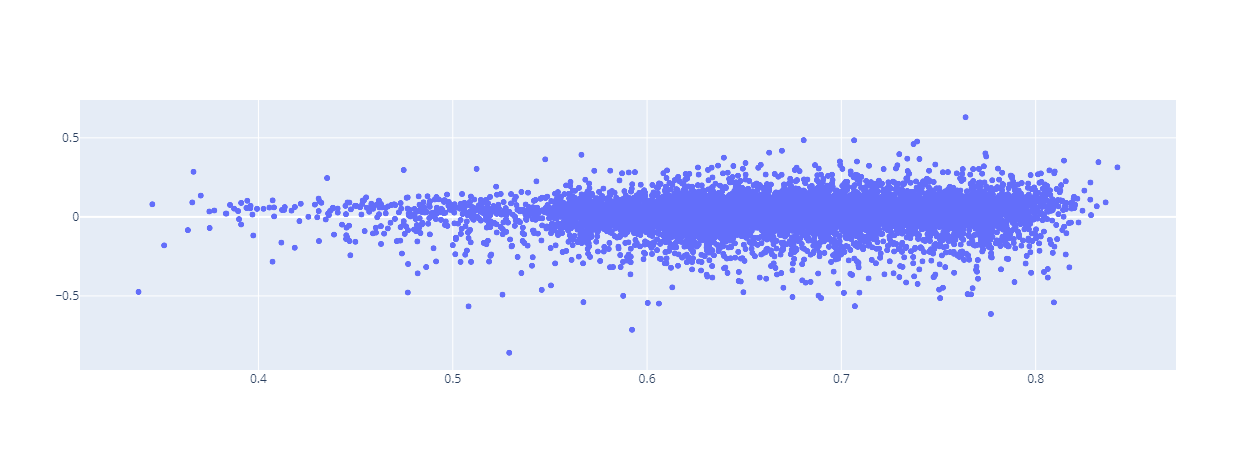

In [48]:
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(
    go.Scattergl(x=eval_tr.preds, y=eval_tr.norm_profit, mode='markers')
)
fig

In [ ]:
eval_tr.sort_values('preds', ascending=False).to_excel('XGBoostExamine.xlsx')

In [ ]:
eval_tr[['preds', 'norm_profit']].corr()

In [ ]:
eval_tr.plot('preds', 'norm_profit', kind='scatter')

In [ ]:
eval_tr[['preds', 'norm_profit']].corr()

In [ ]:
import numpy as np

def select_signals_rand(df):
    indices = np.random.choice(df.shape[0], size=2, replace=False)
    return df.iloc[indices]

In [ ]:
#monte carlo simulation
import progressbar
runs = 5
rand_prof = []
for sim in progressbar.progressbar(range(runs)):
    selected_rand_train = eval_tr.groupby('date').apply(select_signals_rand)
    rand_prof.append(selected_rand_train.norm_profit.mean())
np.mean(rand_prof), np.std(rand_prof)

In [ ]:
def select_signals(df):
    #df = df.loc[df.preds >= 0.5]
    df = df.sort_values('preds', ascending=False)
    #df = df.sort_values('volatility', ascending=False)
    df.drop_duplicates( subset=['symbol'], keep='first')
    return df.iloc[:2]

In [ ]:
best_selection = eval_tr.groupby('date').apply(select_signals)

In [ ]:
best_selection.norm_profit.mean()

In [ ]:
best_selection.norm_profit.mean()

In [ ]:
best_selection.norm_profit.mean()

In [ ]:
best_selection.norm_profit.mean()

In [ ]:
best_selection.norm_profit.mean()

In [ ]:
best_selection.norm_profit.mean()

In [ ]:
best_selection.norm_profit.mean()

In [ ]:
best_selection.norm_profit.mean()

In [ ]:
entries = pd.read_parquet('backtesting/actual_entries.parquet')

In [ ]:
entries[['date', 'symbol']].sort_values('date')

In [ ]:
import datetime as dt
best_selection[['symbol']].loc[dt.datetime(2011, 1, 5)]

In [ ]:
entries.sort_values('date')

In [ ]:
entries.drop_duplicates(subset=['symbol'], keep='first').iloc[:40].index

In [ ]:
best_selection.norm_profit.mean()

In [ ]:
eval_tr.loc[eval_tr.preds > 0.3]['date'].unique().shape

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
sym_df = eval_tr.loc[(eval_tr.MFIROC==1) & (eval_tr.symbol=='A')]
fig.add_trace(
    go.Scatter(x=sym_df.date, y=sym_df.norm_profit, name='norm profit', mode='markers+lines')
)
fig.add_trace(
    go.Scatter(x=sym_df.date, y=sym_df.lag_eavg_profit, name='eprof', mode='markers+lines')
)
fig

In [32]:
import numpy as np

eval_tr.columns[np.argsort(rfc.feature_importances_)]

Index(['RSIROC', 'MFIROC', 'STOROC', 'mfi', 'rsi', 'sto',
       'sector_ma_diff_norm', 'volatility', 'roc', 'equity_curve_ratio',
       'sig_count', 'bba', 'dch'],
      dtype='object')

In [ ]:
np.argsort(xgb_clf.feature_importances_)

### Lead ROC analysis

In [ ]:
import datetime as dt
import seaborn
import random
import plotly.graph_objects as go
sub_df = feature_df.loc[feature_df['date'] >= dt.datetime(2014, 1, 1)][feat_col[:4] + ['fut_roc']]
indices = list(range(sub_df.shape[0]))
random.shuffle(indices)
sub_df = sub_df.iloc[indices[:100000]]
fig = go.Figure()
fig.add_trace(
    go.Scattergl(x=sub_df.rsi, y=sub_df.fut_roc, mode='markers')
)
fig

In [ ]:
import datetime as dt
import seaborn
import random
sub_df = feature_df.loc[feature_df['date'] >= dt.datetime(2014, 1, 1)][feat_col[:4] + ['fut_roc']]
indices = list(range(sub_df.shape[0]))
random.shuffle(indices)
sub_df = sub_df.iloc[indices[:100000]]
fig = go.Figure()
fig.add_trace(
    go.Scattergl(x=sub_df.sto, y=sub_df.fut_roc, mode='markers')
)
fig

In [ ]:
sub_df.corr()

In [ ]:
sub_df.corr()